https://github.com/pymc-devs/pymc/issues/4273
https://github.com/pymc-devs/pymc/issues/3844

In [1]:
import numpy as np
import sympy
import sunode
import sunode.wrappers.as_theano
import pymc3 as pm

times = np.arange(1900,1921,1)
lynx_data = np.array([
    4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
    8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6
])
hare_data = np.array([
    30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
    27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7
])

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#global lotka_volterra
#global SympyProblem
global step_method
def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.
    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': p.alpha * y.hares - p.beta * y.lynx * y.hares,
        'lynx': p.delta * y.hares * y.lynx - p.gamma * y.lynx,
    }


with pm.Model() as model:
    hares_start = pm.HalfNormal('hares_start', sd=50)
    lynx_start = pm.HalfNormal('lynx_start', sd=50)
    ratio = pm.Beta('ratio', alpha=0.5, beta=0.5)
    fixed_hares = pm.HalfNormal('fixed_hares', sd=50)
    fixed_lynx = pm.Deterministic('fixed_lynx', ratio * fixed_hares)
    period = pm.Gamma('period', mu=10, sd=1)
    freq = pm.Deterministic('freq', 2 * np.pi / period)
    log_speed_ratio = pm.Normal('log_speed_ratio', mu=0, sd=0.1)
    speed_ratio = np.exp(log_speed_ratio)
    # Compute the parameters of the ode based on our prior parameters
    alpha = pm.Deterministic('alpha', freq * speed_ratio * ratio)
    beta = pm.Deterministic('beta', freq * speed_ratio / fixed_hares)
    gamma = pm.Deterministic('gamma', freq / speed_ratio / ratio)
    delta = pm.Deterministic('delta', freq / speed_ratio / fixed_hares / ratio)
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={
	    # The initial conditions of the ode. Each variable
	    # needs to specify a theano or numpy variable and a shape.
	    # This dict can be nested.
            'hares': (hares_start, ()),
            'lynx': (lynx_start, ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to theano variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'alpha': (alpha, ()),
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'delta': (delta, ()),
            'extra': np.zeros(1),
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=lotka_volterra,
	# The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('hares_mu', y_hat['hares'])
    pm.Deterministic('lynx_mu', y_hat['lynx'])
    sd = pm.HalfNormal('sd')
    pm.Lognormal('hares', mu=y_hat['hares'], sd=sd, observed=hare_data)
    pm.Lognormal('lynx', mu=y_hat['lynx'], sd=sd, observed=lynx_data)



Even when downgrading Py to < 3.8, the same errors keep appearing. My unique options left are:
1. Emulate a Linux OS & Python
2. Give in at once and see what happpend using Ray, or not paralleliginz at all

In [3]:
with model:
    trace = pm.sample(tune=1000, draws=1000, chains=4, cores=4)

/tmp/ipykernel_17206/2177192547.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=1000, draws=1000, chains=4, cores=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, log_speed_ratio, period, fixed_hares, ratio, lynx_start, hares_start]



[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand 

In [4]:
from pymc3 import summary
summary(trace)

/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_speed_ratio,-0.084,0.078,-0.224,0.065,0.001,0.001,3096.0,2635.0,1.0
hares_start,3.505,0.109,3.294,3.704,0.002,0.002,2085.0,2028.0,1.0
lynx_start,1.886,0.078,1.734,2.029,0.001,0.001,2982.0,2847.0,1.0
ratio,0.820,0.023,0.775,0.862,0.000,0.000,2263.0,2331.0,1.0
fixed_hares,3.336,0.058,3.230,3.442,0.001,0.001,2735.0,2766.0,1.0
fixed_lynx,2.733,0.059,2.628,2.849,0.001,0.001,3009.0,3019.0,1.0
period,10.110,0.165,9.790,10.409,0.003,0.002,2409.0,2580.0,1.0
freq,0.622,0.010,0.603,0.641,0.000,0.000,2409.0,2580.0,1.0
alpha,0.470,0.041,0.387,0.544,0.001,0.001,2583.0,2608.0,1.0
beta,0.172,0.014,0.145,0.199,0.000,0.000,2808.0,2707.0,1.0


/tmp/ipykernel_17206/1367478007.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace)
/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'log_speed_ratio'}>,
        <AxesSubplot:title={'center':'log_speed_ratio'}>],
       [<AxesSubplot:title={'center':'hares_start'}>,
        <AxesSubplot:title={'center':'hares_start'}>],
       [<AxesSubplot:title={'center':'lynx_start'}>,
        <AxesSubplot:title={'center':'lynx_start'}>],
       [<AxesSubplot:title={'center':'ratio'}>,
        <AxesSubplot:title={'center':'ratio'}>],
       [<AxesSubplot:title={'center':'fixed_hares'}>,
        <AxesSubplot:title={'center':'fixed_hares'}>],
       [<AxesSubplot:title={'center':'fixed_lynx'}>,
        <AxesSubplot:title={'center':'fixed_lynx'}>],
       [<AxesSubplot:title={'center':'period'}>,
        <AxesSubplot:title={'center':'period'}>],
       [<AxesSubplot:title={'center':'freq'}>,
        <AxesSubplot:title={'center':'freq'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSub

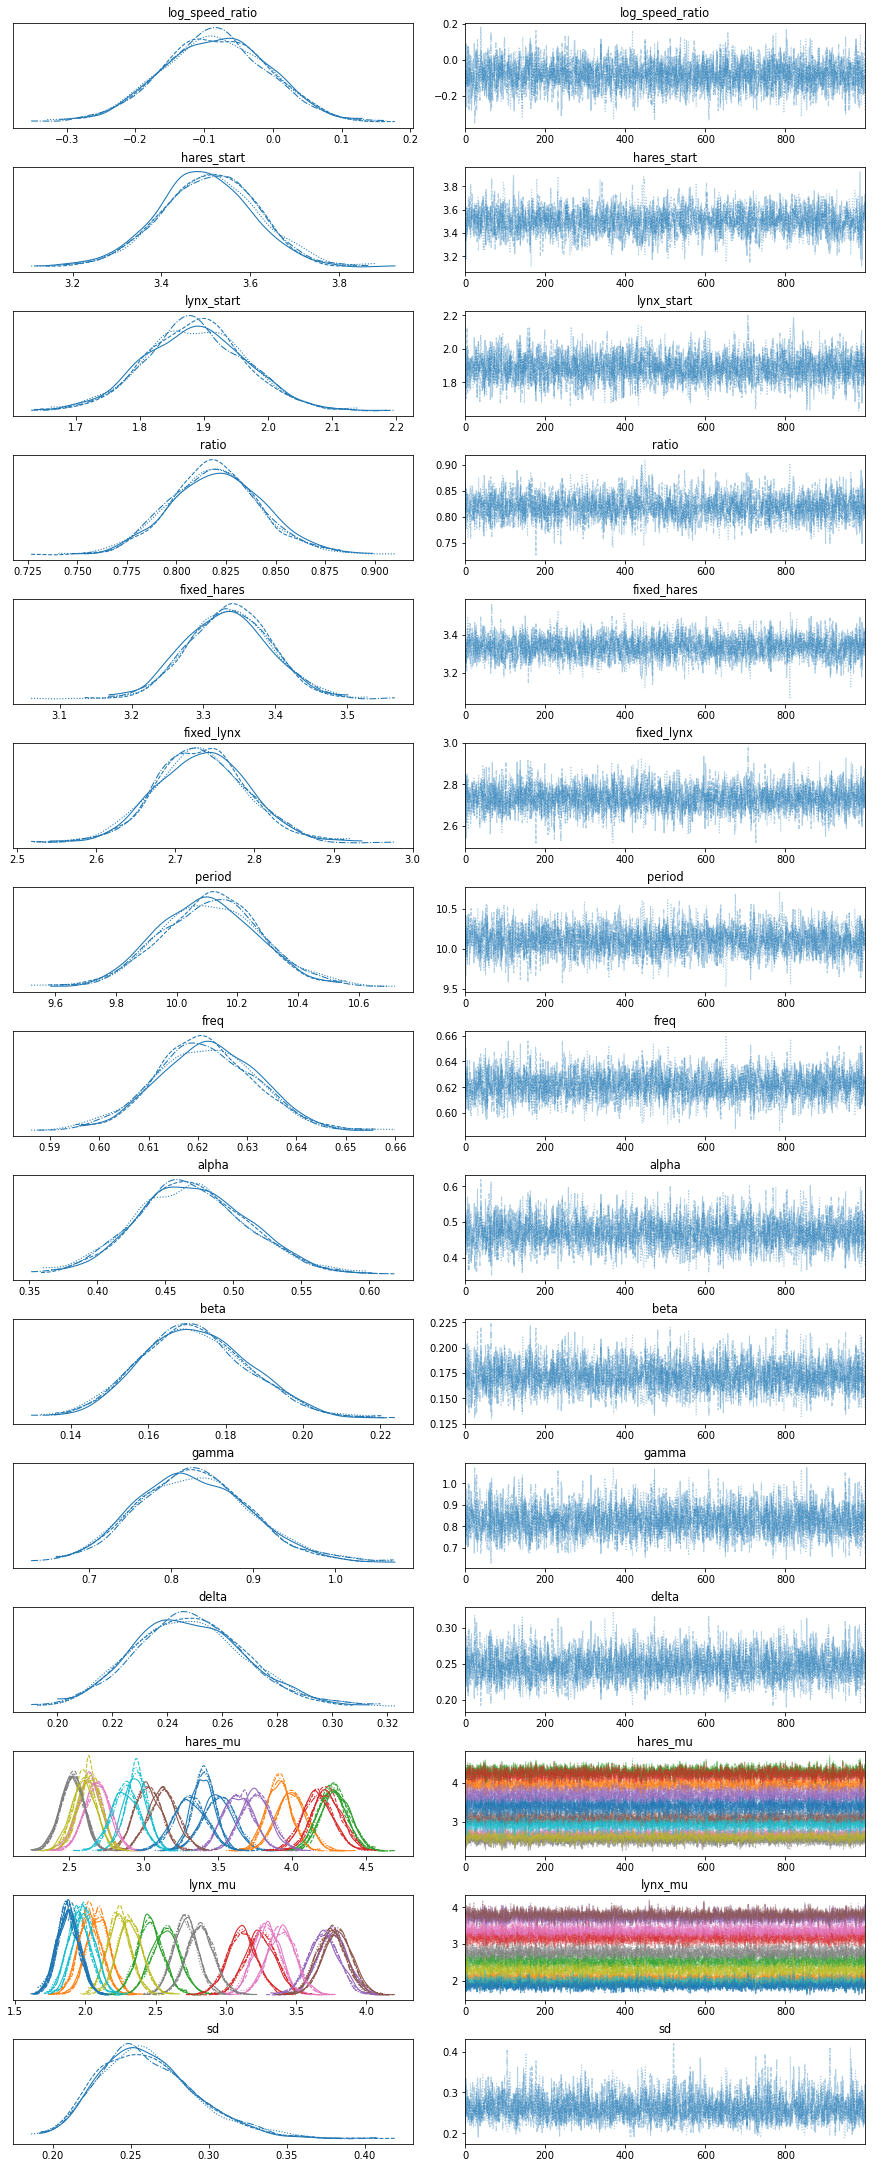

In [5]:
from pymc3 import traceplot
traceplot(trace)